In [1]:
from Functions import *


In [2]:
''' loop parameters '''
NN = 300
f1_list = np.linspace(-0.02,0.02,NN)+9.73265
duration = np.zeros(NN)

if_plot = 0
if_loop = 1


In [3]:
''' Beam parameters '''
N = 2048			# number of sampling points
E0 = 12665			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

''' OE parameters '''
hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}

In [4]:
''' Define beamline '''
crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
							  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)
if alphaAsym <= 0:
	print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = 10.
f2 = 10.

devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

b 1.00
b 1.00
b 9.52
crystal 2 incidence angle: 56.31 degrees
crystal 2 exit angle: 5.01 degrees
b 1.00
b 0.10


In [5]:
''' propagate and plot beam profiles '''
blockPrint()
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

pulse.propagate(beamline=mono_beamline, screen_names=['im1','focus','im2'])
tfin = time.time()

C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


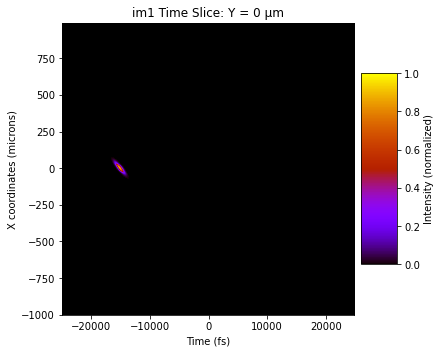

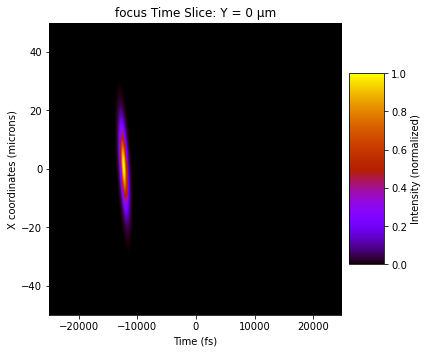

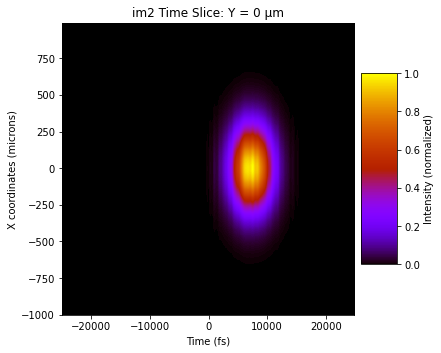

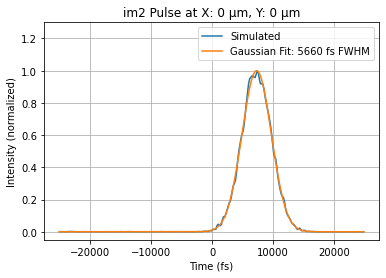

In [6]:
''' plot time slices '''
enablePrint()
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
pulse.imshow_time_slice('im1',shift=shift)
pulse.imshow_time_slice('focus', shift = shift)
pulse.imshow_time_slice('im2', shift = shift)
pulse.plot_pulse('im2', shift = shift)

''' IO '''
path = '../{} eV'.format(E0)
make_dir(path)

fig_path = path+'/f1_scan'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'pulse_duration_{}_{}keV'.format(
	hkl_, round(beam_params['photonEnergy']/1000.,4))

blockPrint()

In [7]:
''' ball park plots '''
if if_plot == 1:
	for f1 in f1_list:
		fig_name = fig_path+'/time_profile_f1={}.png'.format(round(f1,5))
		#if os.path.exists(fig_name):
		#	continue
		devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
		mono_beamline = beamline.Beamline(devices)
		beam_params['photonEnergy'] = E0

		pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
		pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
		pulse.imshow_time_slice('im2')
		plt.savefig(fig_name)
		plt.close('all')
        

In [ ]:
''' optimization '''
if if_loop == 1:
	for i,f1 in enumerate(f1_list):
		devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
		mono_beamline = beamline.Beamline(devices)
		beam_params['photonEnergy'] = E0

		pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

		print('Number of spectral components: {:d}'.format(pulse.N))
		pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
		centroid, duration[i] = pulse.pulse_duration('im2')

	with h5py.File(path+fname+'.h5','w') as f:
		f.create_dataset('f1', data=f1_list)
		f.create_dataset('duration', data=duration)



C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
plt.figure()
